### Importing Necessary Libraries

In [2]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pytransit import RoadRunnerModel
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

### Creating Transit Dataset (~ 2 seconds)

In [4]:
N_SAMPLES = 500
NOISE_PPM = 300
light_curves, labels = [], []
label_dict, reverse_label_dict = {"No-Planet": 0, "Planet": 1}, {1: "Planet", 0: "No-Planet"}

time = np.linspace(-0.5, 0.5, 1500)
transit_model = RoadRunnerModel('power-2')

def simulate_transit_curves():
    radius_ratio = np.random.normal(0.10, 0.002)
    limb_coeff = np.random.uniform(0, 0.6, size=(1, 2))
    zero_epoch = np.random.normal(0, 0.001)
    orbital_period = np.random.normal(1.0, 0.01)
    scaled_semimajor = np.random.normal(4.2, 0.1)
    inclination = np.random.uniform(0.48*np.pi, 0.5*np.pi)
    eccentricity = np.random.uniform(0.0, 0.25)

    transit_model.set_data(time)
    light_curve = transit_model.evaluate(
        k=radius_ratio,
        ldc=limb_coeff,
        t0=zero_epoch,
        p=orbital_period,
        a=scaled_semimajor,
        i=inclination,
        e=eccentricity
    )
    light_curve += np.random.normal(0, NOISE_PPM * 1e-6, size=light_curve.shape)
    return light_curve

def simulate_flat_curves():
    light_curve = np.ones_like(time)
    light_curve += np.random.normal(0, NOISE_PPM * 1e-6, size=light_curve.shape)
    return light_curve

print("Simulating Transit Light Curves")
for _ in tqdm(range(N_SAMPLES)):
    light_curves.append(simulate_transit_curves())
    labels.append(1)

print("Simulating no-Transit Light Curves")
for _ in tqdm(range(N_SAMPLES)):
    light_curves.append(simulate_flat_curves())
    labels.append(0)

shuffle_idx = np.random.permutation(len(labels))

light_curves = torch.tensor(np.array(light_curves), dtype=torch.float32)[shuffle_idx]
labels = torch.tensor(np.array(labels), dtype=torch.int64)[shuffle_idx]

Simulating Transit Light Curves


100%|██████████| 500/500 [00:00<00:00, 13707.32it/s]


Simulating no-Transit Light Curves


100%|██████████| 500/500 [00:00<00:00, 38652.19it/s]


### Transforms, Dataloader


In [5]:
X_train, X_test, y_train, y_test = train_test_split(light_curves, labels, test_size=0.1)

trainDataset = TensorDataset(X_train, y_train)
testDataset = TensorDataset(X_test, y_test)

batchSize = 16
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)

### Example Visualization

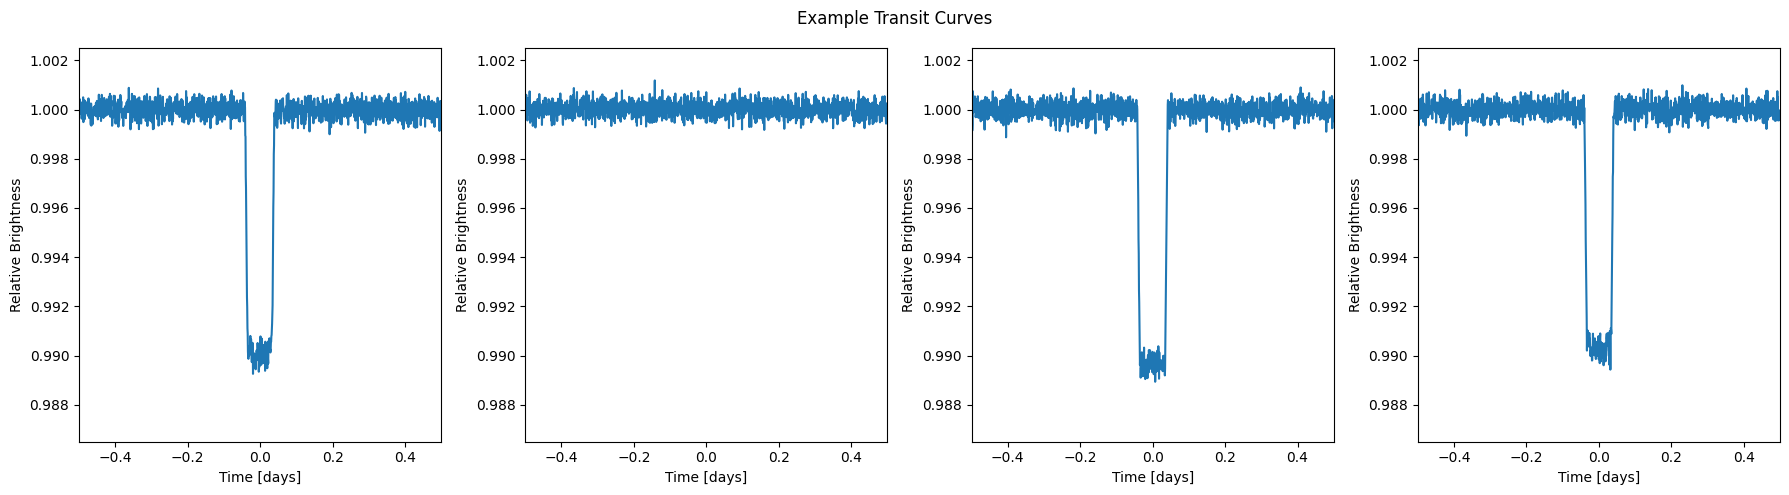

In [16]:
X, y = next(iter(trainLoader))

_, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))
for i in range(4):
    ax[i].plot(time, X[i], c=None)
    ax[i].autoscale(axis='x', tight=True)
    plt.setp(ax, xlabel='Time [days]', ylabel='Relative Brightness', xlim=time[[0, -1]], ylim=(0.9865, 1.0025))

plt.suptitle("Example Transit Curves")
plt.tight_layout()
plt.show()

### ResNet 1D Network
Best performing network for univariate time series classification. Source from https://arxiv.org/abs/1809.04356

In [17]:
class ResnNetBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[7, 5, 3]):
        super(ResnNetBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_sizes[0], padding=kernel_sizes[0]//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_sizes[1], padding=kernel_sizes[1]//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_sizes[2], padding=kernel_sizes[2]//2)
        self.bn3 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return F.relu(out)

class TransitCurveClassifierCNN(nn.Module):
    def __init__(self, input_channels=1, n_classes=1):
        super(TransitCurveClassifierCNN, self).__init__()
        self.block1 = ResnNetBlock1D(input_channels, 64)
        self.block2 = ResnNetBlock1D(64, 128)
        self.block3 = ResnNetBlock1D(128, 128)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_avg_pool(x).squeeze(-1)
        return self.fc(x)

### Loss function, Optimizer, Model Object

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TransitCurveClassifierCNN()
model.to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lossfn = nn.BCEWithLogitsLoss()

### Train Function

In [27]:
def trainModel(model, lossfn, optimizer, iteration):
    epochs = iteration

    trainLoss = []

    iteration_count = 0
    total_iterations = len(trainLoader) * epochs

    with tqdm(total=total_iterations, desc="Training Progress") as pbar:

        for _ in range(epochs):
            model.train()
            batchLoss = []

            for X, y in trainLoader:
                X, y = X.to(device), y.to(device)
                yHat = model(X.unsqueeze(1))
                loss = lossfn(yHat.squeeze(), y.to(torch.float32))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batchLoss.append(loss.item())
                iteration_count += 1

                if iteration_count % 200 == 0:
                    avg_train_loss = np.mean(batchLoss)
                    trainLoss.append(avg_train_loss)
                    pbar.set_postfix_str(f"Total Loss: {avg_train_loss:.3f}")
                pbar.update(1)

    checkpoint = {
        "weights": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, "task_sequential.pth")

    return trainLoss, model

### Training the model (~ 10 seconds)

In [28]:
trainLoss, model = trainModel(model, lossfn, optimizer, iteration=10)

Training Progress: 100%|██████████| 570/570 [00:10<00:00, 54.55it/s, Total Loss: 0.001]


### Loading the pre-trained weights

In [ ]:
checkpoint_dir = "task_sequential.pth" # Edit the model checkpoint path
checkpoint = torch.load(checkpoint_dir, weights_only=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device=device)
model.load_state_dict(checkpoint['weights'])

<All keys matched successfully>

### Testing the model

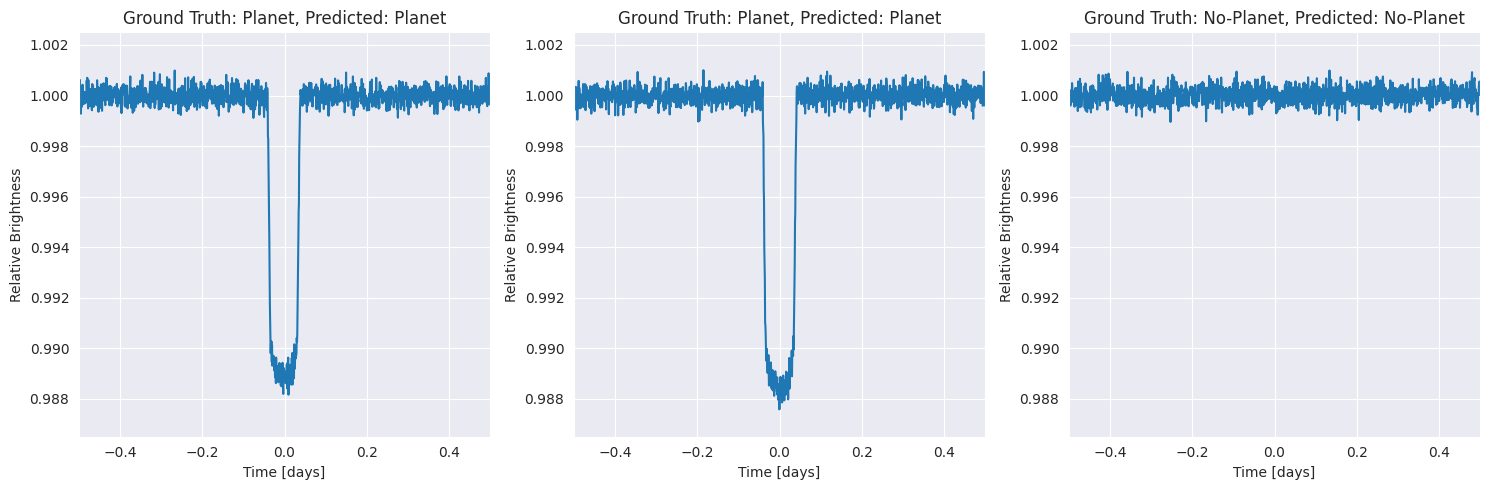

In [30]:
Xtest, ytest = next(iter(testLoader))
model.eval()
yPredtest = model(Xtest.unsqueeze(1).to(device))

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i in range(3):
    ax[i].plot(time, Xtest[i], c=None)
    ax[i].autoscale(axis='x', tight=True)
    ax[i].set_title(f"Ground Truth: {reverse_label_dict[ytest[i].item()]}, Predicted: {reverse_label_dict[round(torch.sigmoid(yPredtest[i]).item())]}")
    plt.setp(ax, xlabel='Time [days]', ylabel='Relative Brightness', xlim=time[[0, -1]], ylim=(0.9865, 1.0025))

plt.tight_layout()
plt.show()

### One hot encoding

In [31]:
all_logits, all_labels = [], []

with torch.no_grad():
    for x, labels in testLoader:
        x = x.to(device)
        labels = labels.to(device)

        logits = model(x.unsqueeze(1))
        loss = lossfn(logits.squeeze(), labels.float())
        probs = torch.round(F.sigmoid(logits))

        all_logits.append(probs.cpu())
        all_labels.append(labels.cpu())

all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim=0)

class_probs = all_logits.numpy()
true_class = all_labels.numpy() == 1

### Evaluation Metrics (ROC, AUC, Histograms)

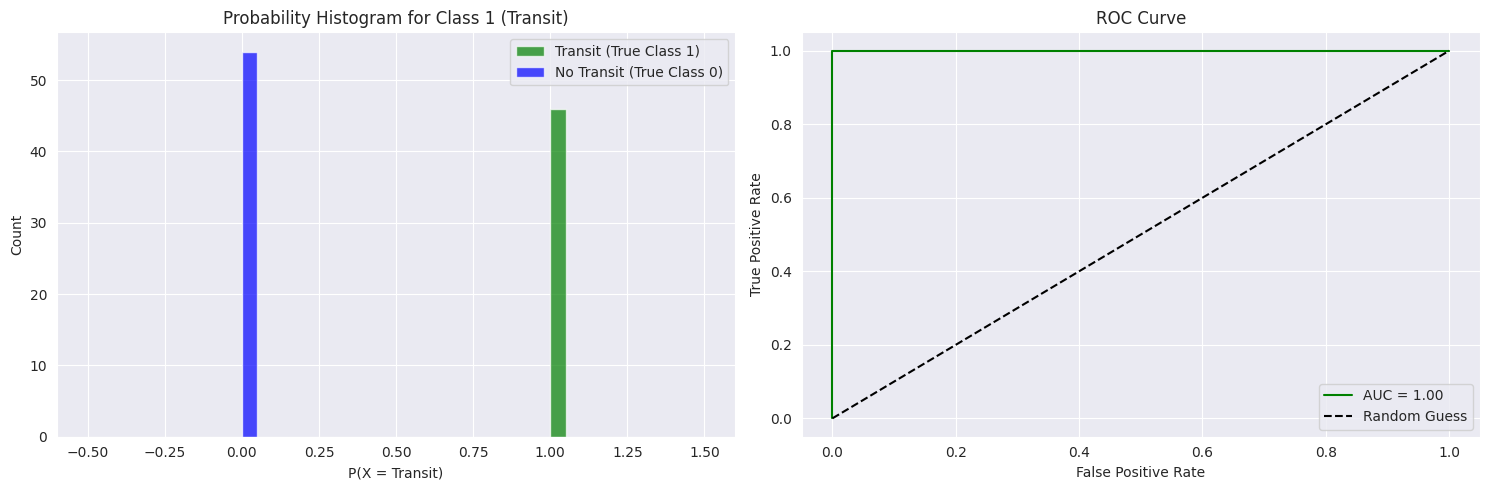

In [32]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].hist(class_probs[true_class], bins=20, alpha=0.7, color='green', label="Transit (True Class 1)")
ax[0].hist(class_probs[~true_class], bins=20, alpha=0.7, color='blue', label="No Transit (True Class 0)")
ax[0].set_title("Probability Histogram for Class 1 (Transit)")
ax[0].set_xlabel("P(X = Transit)")
ax[0].set_ylabel("Count")
ax[0].legend()

fpr, tpr, _ = roc_curve(true_class, class_probs)
roc_auc = auc(fpr, tpr)

ax[1].plot(fpr, tpr, 'g', label=f"AUC = {roc_auc:.2f}")
ax[1].plot([0, 1], [0, 1], 'k--', label="Random Guess")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC Curve")
ax[1].legend()

plt.tight_layout()
plt.show()

### Experimenting with Real Kepler Data (Planet 1: Simple Light Curve from astropy)

Planet 1 Details
---------------------------------
Planet Period: 2.2055172439293367 d
Planet Transit Time: 2009-05-02T20:51:16.338
Planet presence likelihood: 99.9970%


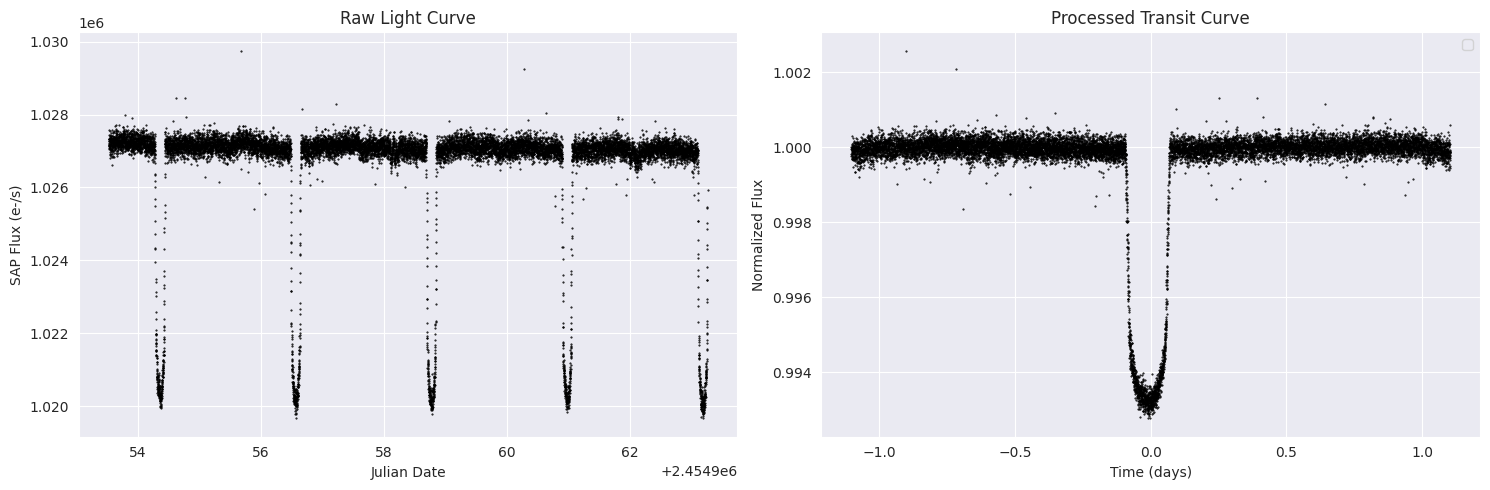

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import TimeSeries, BoxLeastSquares, aggregate_downsample

filename = get_pkg_data_filename('timeseries/kplr010666592-2009131110544_slc.fits')
ts = TimeSeries.read(filename, format='kepler.fits')

## Box Least Square to estimate the period
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
results = periodogram.autopower(0.2 * u.day)
best = np.argmax(results.power)
period = results.period[best]
transit_time = results.transit_time[best]
print("Planet 1 Details")
print("---------------------------------")
print("Planet Period: {}".format(period))
print("Planet Transit Time: {}".format(transit_time))

## Folding the time series using period, transit_time
ts_folded = ts.fold(period=period, epoch_time=transit_time)
mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])
ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median
ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)

## Passing the binned input to model
lc_tensor = torch.tensor(np.array(ts_binned['sap_flux_norm']), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
ypred = torch.sigmoid(model(lc_tensor))
print("Planet presence likelihood: {:.4f}%".format(ypred.item() * 100))

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
ax[0].set_xlabel('Julian Date')
ax[0].set_ylabel('SAP Flux (e-/s)')
ax[0].set_title("Raw Light Curve")
ax[1].plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Normalized Flux')
ax[1].set_title("Processed Transit Curve")
plt.legend()
plt.tight_layout()
plt.show();

### Experimenting with Real Kepler Data (Planet 2: File from Kepler Archive (https://archive.stsci.edu/kepler/download_options.html))

Planet 2 Details
---------------------------------
Planet Period: 9.379915487533015 d
Planet Transit Time: 2013-04-17T14:32:20.896
Planet presence likelihood: 100.0000%


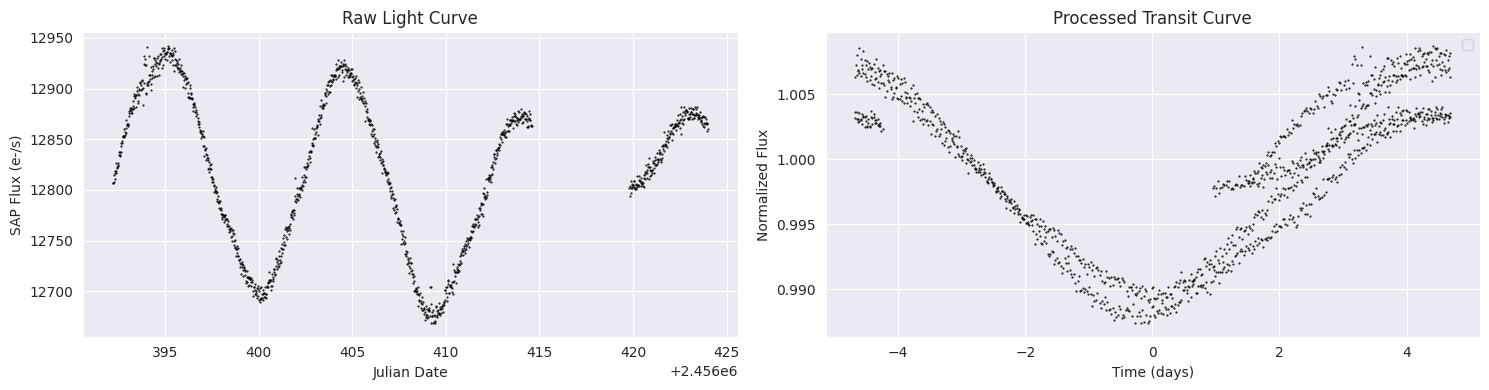

In [ ]:
filename2 = "kplr001429092-2013131215648_llc.fits"
ts2 = TimeSeries.read(filename2, format='kepler.fits')

## Box Least Square to estimate the period
periodogram = BoxLeastSquares.from_timeseries(ts2, 'sap_flux')
results = periodogram.autopower(0.2 * u.day)
best = np.argmax(results.power)
period2 = results.period[best]
transit_time2 = results.transit_time[best]
print("Planet 2 Details")
print("---------------------------------")
print("Planet Period: {}".format(period2))
print("Planet Transit Time: {}".format(transit_time2))

## Folding the time series using period, transit_time
ts_folded2 = ts2.fold(period=period2, epoch_time=transit_time2)
mean, median, stddev = sigma_clipped_stats(ts_folded2['sap_flux'])
ts_folded2['sap_flux_norm'] = ts_folded2['sap_flux'] / median
ts_binned2 = aggregate_downsample(ts_folded2, time_bin_size=0.03 * u.day)

## Passing the binned input to model
lc_tensor2 = torch.tensor(np.array(ts_binned2['sap_flux_norm']), dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
ypred2 = torch.sigmoid(model(lc_tensor2))
print("Planet presence likelihood: {:.4f}%".format(ypred2.item() * 100))

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].plot(ts2.time.jd, ts2['sap_flux'], 'k.', markersize=1)
ax[0].set_xlabel('Julian Date')
ax[0].set_ylabel('SAP Flux (e-/s)')
ax[0].set_title("Raw Light Curve")
ax[1].plot(ts_folded2.time.jd, ts_folded2['sap_flux_norm'], 'k.', markersize=1)
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Normalized Flux')
ax[1].set_title("Processed Transit Curve")
plt.legend()
plt.tight_layout()
plt.show();